# Lecture 17a - Cluster Validity Metrics

In [4]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

## K-Means Applications

K-Means is a very popular algorithm and is commonly used in a variety of applications, such as: market segmentation, document clustering, image segmentation, image compression, etc.

The *goal* usually when we undergo a cluster analysis is either:

1. Get a meaningful intuition of the structure of the data we are dealing with.

2. Cluster-then-predict where different models will be built for different subgroups. An example of that is clustering patients into different subgroups (based on some feature map) and build a model for each subgroup to predict the probability of the risk of having a heart attack.

Let's take a look at two case applications for K-Means: Image Compression and Data Segmentation.

### Example: K-Means as Data Segmentation

In [5]:
from scipy import spatial
from scipy.spatial.distance import cdist
from numpy.random import permutation

def KMeans(X, K, MaxIter = 10000, Thresh = 1e-5, Visualization = True):
    '''This function implements K-Means algorithm. 
    Where the data X will be partitioned into K clusters.
    Data matrix X is of size NxD, where N is the number of points and D the dimension of the data.'''

    #Initialize Cluster Centers by drawing Randomly from Data (can use other
    # methods for initialization...)
    N       = X.shape[0] # number of data points
    rp      = np.random.permutation(N); # shuffle the data (random permutation)
    centers = X[rp[0:K],:]; # select first K data points as cluster centroids
    
    if Visualization:
        fig = plt.figure()
        plt.subplot(1,2,1)
        plt.scatter(X[:,0],X[:,1],c='b')
        plt.plot(centers[:,0],centers[:,1],'xr',markersize=20)
        plt.title('Randomly select K='+str(K)+' data points as Centroids')
        plt.show()
    
    diff    = np.inf;
    iter    = 0;
    while((diff > Thresh) & (iter < MaxIter)):
        D   = spatial.distance.cdist(X, centers) # compute the distance of every point to every cluster centroid
        L   = np.argmin(D, axis=1) # Assign data to closest cluster representative (using Euclidean distance)

        # Visualization
        if Visualization:
            plt.subplot(1,2,1)
            plt.scatter(X[:,0],X[:,1],c=L)
            plt.plot(centers[:,0],centers[:,1],'xr',markersize=20)
            plt.title('Membership Assignment')
            
        #Update cluster centers
        centersPrev = centers.copy()
        for i in range(K):
            centers[i,:] = np.mean(X[L == i,:], axis=0) # New cluster centroids will be the average of all points assigned to it

        # Visualization
        if Visualization:
            plt.subplot(1,2,2)
            plt.scatter(X[:,0],X[:,1],c=L)            
            plt.plot(centers[:,0],centers[:,1],'xr',markersize=20)
            plt.title('Update Cluster Centroids')
            plt.pause(1)
        
        #Update diff & iteration count for stopping criteria
        diff = np.linalg.norm(centersPrev - centers)
        iter = iter+1
    return centers, L

# Plotting function for synthetically generated data
def Plotting(X, true_labels, L, name):
    if len(true_labels)>0:
        fig = plt.figure(figsize=(12,4))
        fig.add_subplot(1,2,1)
        plt.scatter(X[:,0],X[:,1],c=true_labels)
        plt.title(name)
    else:
        fig = plt.figure(figsize=(12,4))
        fig.add_subplot(1,2,1)
        plt.scatter(X[:,0],X[:,1],c='b')
        plt.title(name)
    fig.add_subplot(1,2,2)
    plt.scatter(X[:, 0], X[:, 1], c=L)
    plt.title("K-Means Clustering Results")

In [6]:
from sklearn import datasets

# Create synthetically generate data
n_samples = 1500
X1, T1 = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1)               # Blobs data
X2, T2 = datasets.make_blobs(n_samples=n_samples,cluster_std=[1.0, 2.5, 0.5],centers=3) # Different Variance Blobs data
X3, T3 = datasets.make_moons(n_samples=n_samples, noise=.05)                            # Moons data
X4, T4 = datasets.make_circles(n_samples, noise=.05, factor=0.5)                        # Circles data
X5     = np.dot(X1, [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]])             # Anisotropicly distributed data
X6     = np.vstack((X1[T1 == 0][:500], X1[T1 == 1][:100], X1[T1 == 2][:10]))            # Unevenly sized Blobs data
T6     = np.hstack((np.zeros(500),np.ones(100),2*np.ones(10)))

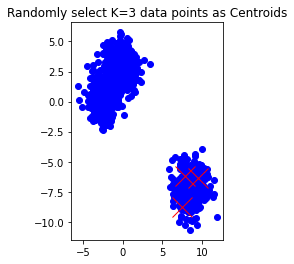

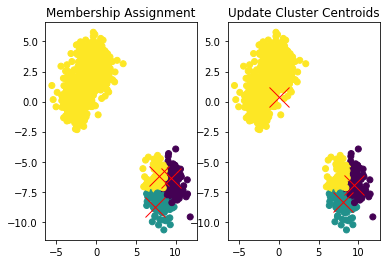

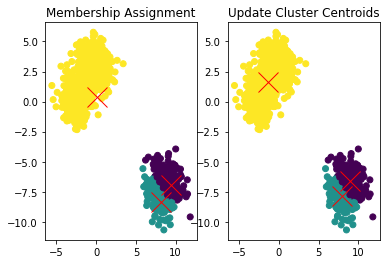

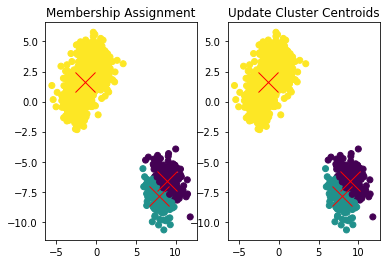

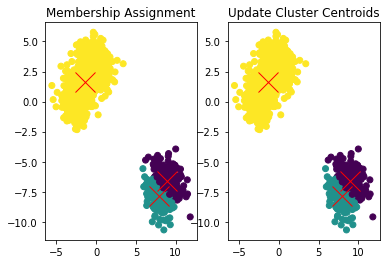

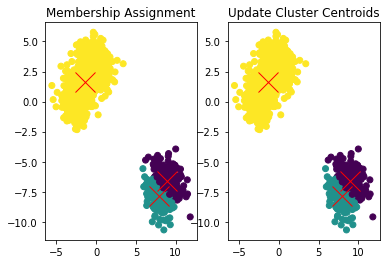

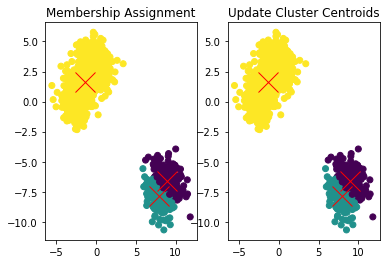

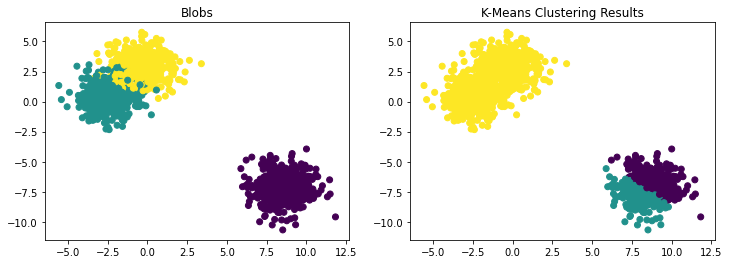

In [8]:
NoClusters = 3
C1, L1 = KMeans(X1, NoClusters, Visualization = True)
Plotting(X1, T1, L1, 'Blobs')

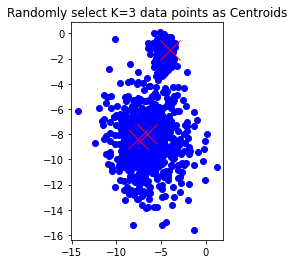

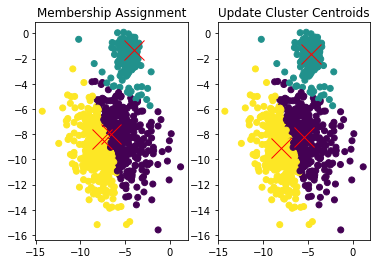

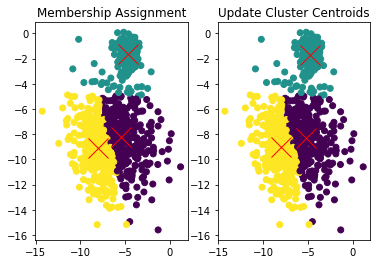

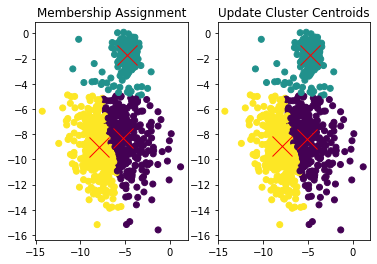

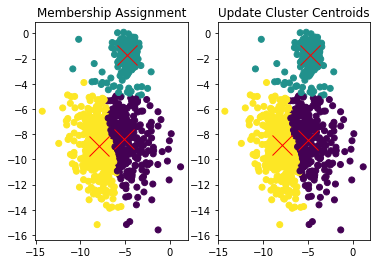

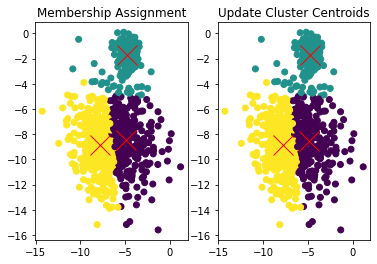

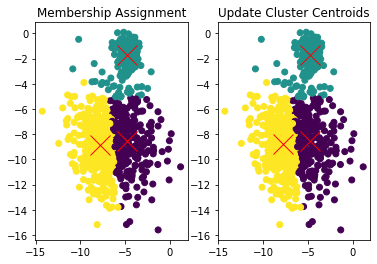

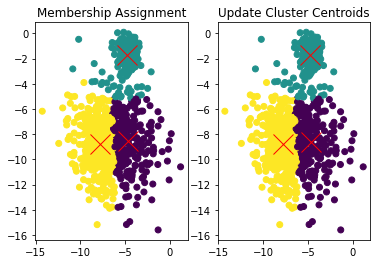

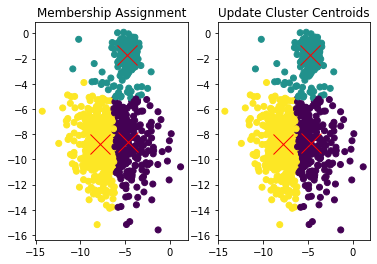

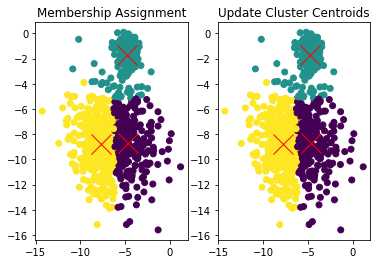

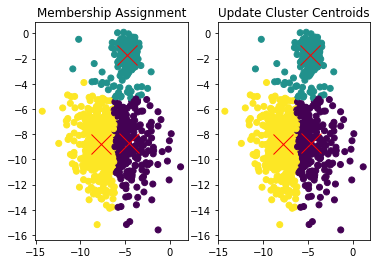

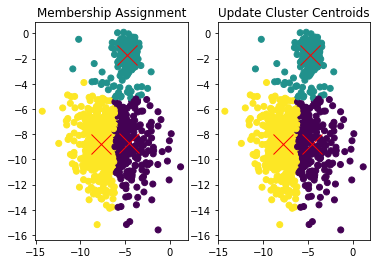

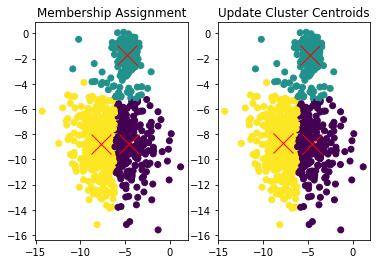

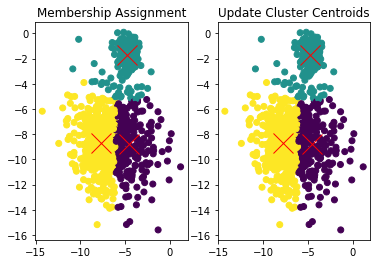

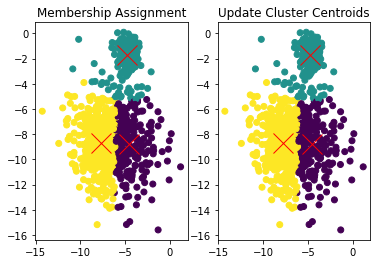

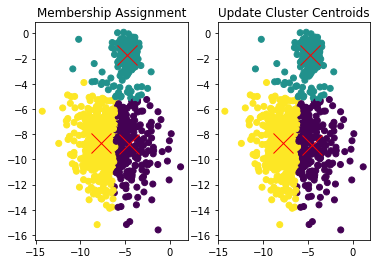

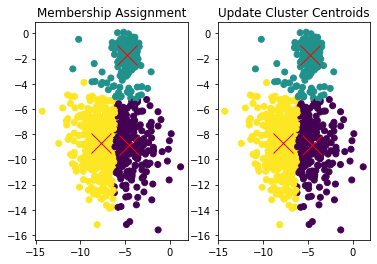

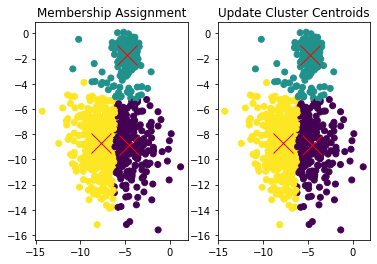

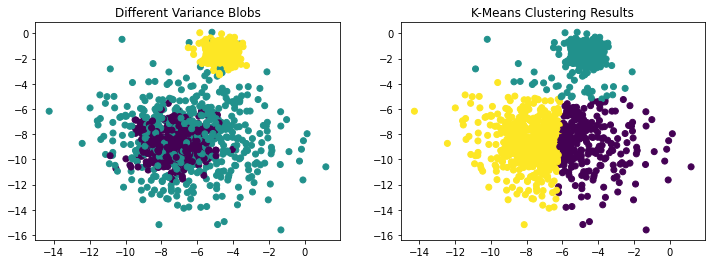

In [9]:
NoClusters = 3
C2, L2 = KMeans(X2, NoClusters, Visualization = True)
Plotting(X2, T2, L2, 'Different Variance Blobs')

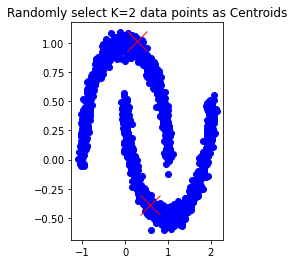

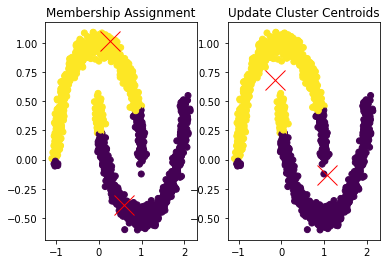

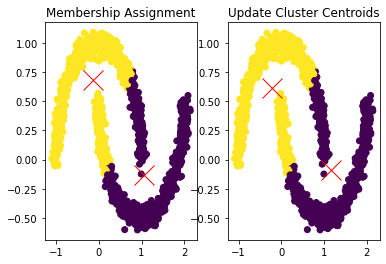

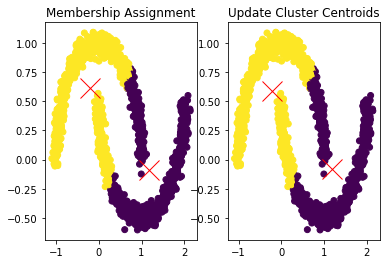

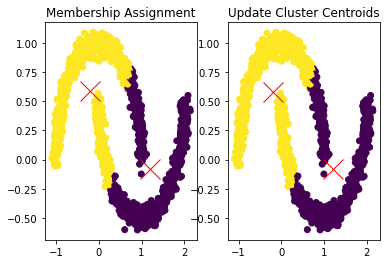

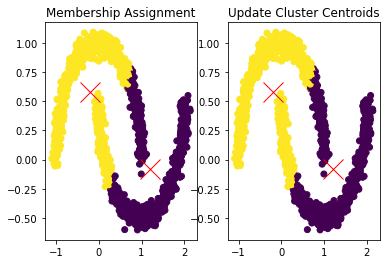

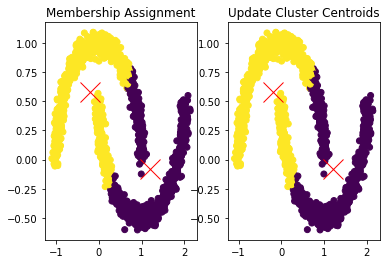

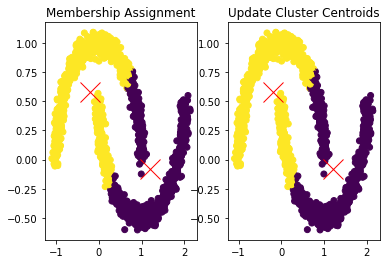

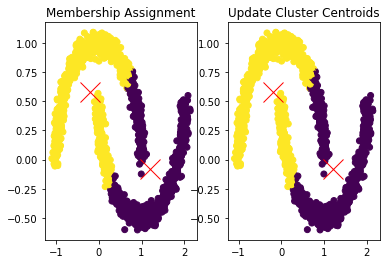

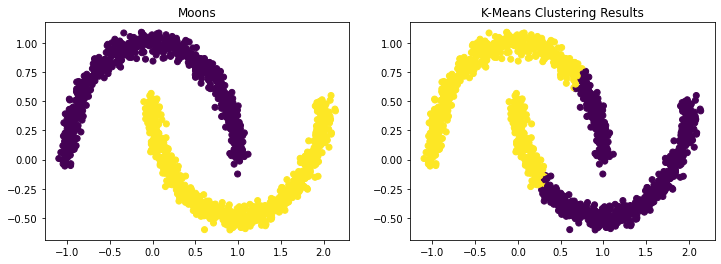

In [11]:
NoClusters = 2
C3, L3 = KMeans(X3, NoClusters, Visualization = True)
Plotting(X3, T3, L3, 'Moons')

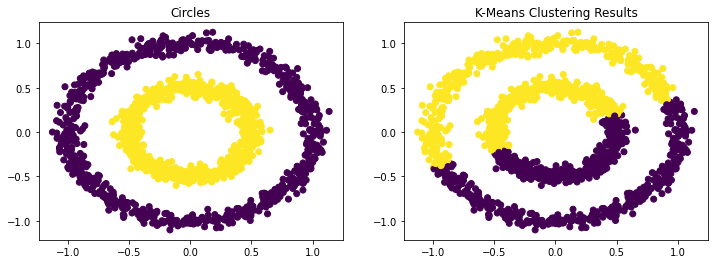

In [12]:
NoClusters = 2
C4, L4 = KMeans(X4, NoClusters, Visualization = False)
Plotting(X4, T4, L4, 'Circles')

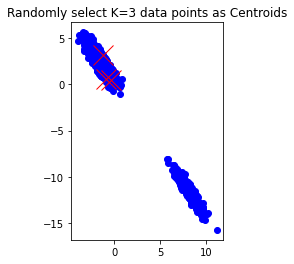

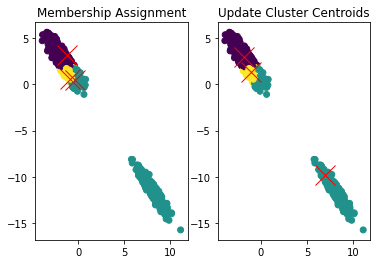

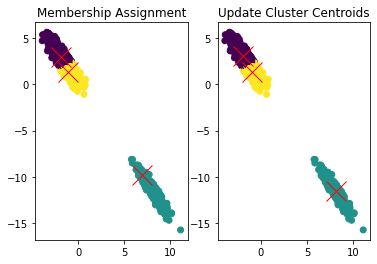

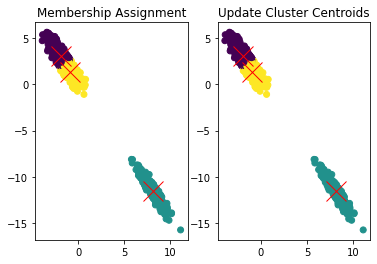

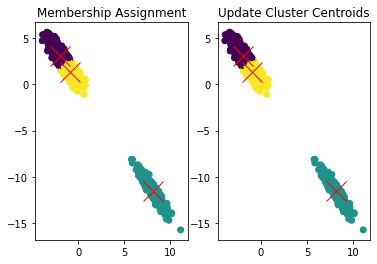

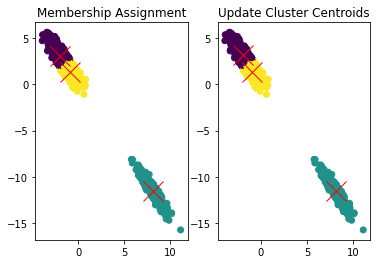

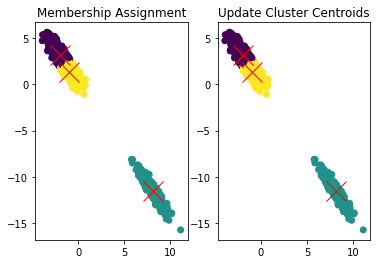

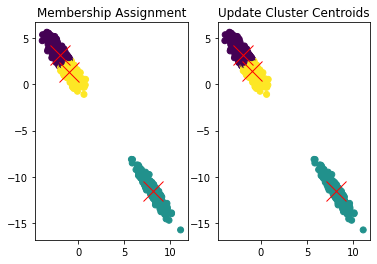

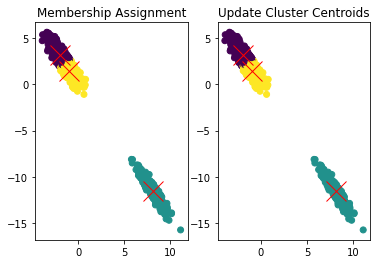

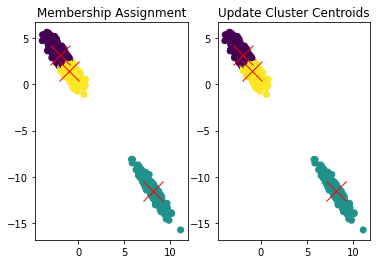

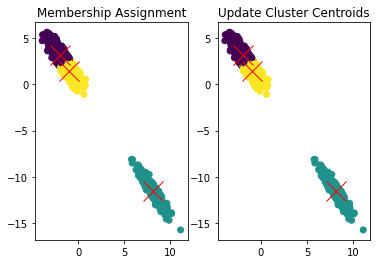

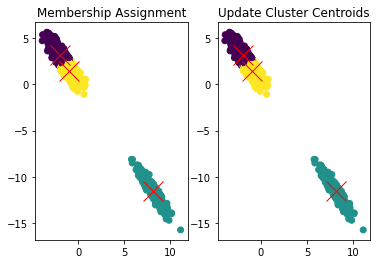

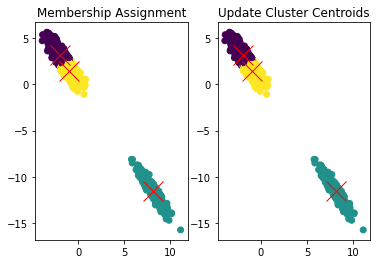

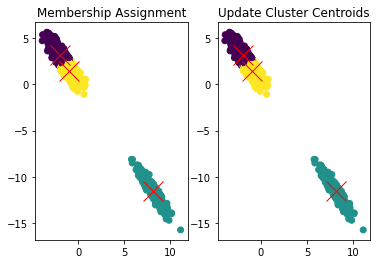

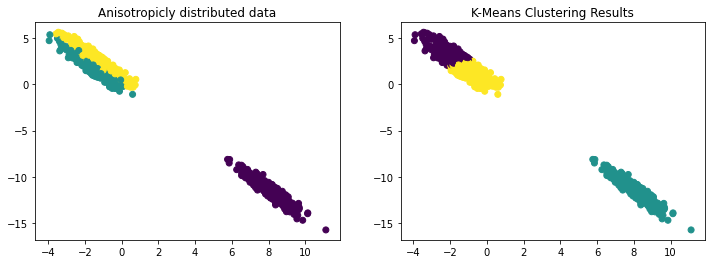

In [14]:
NoClusters = 3
C5, L5 = KMeans(X5, NoClusters, Visualization = True)
Plotting(X5, T1, L5, 'Anisotropicly distributed data')

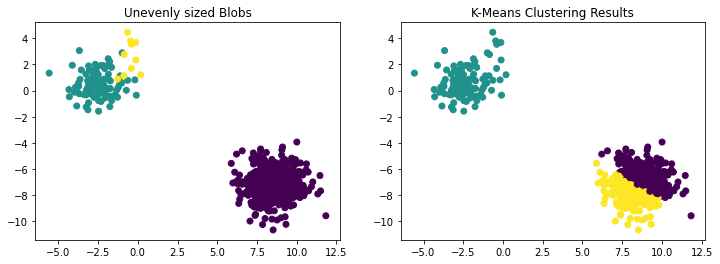

In [15]:
NoClusters = 3
C6, L6 = KMeans(X6, NoClusters, Visualization = False)
Plotting(X6, T6, L6, 'Unevenly sized Blobs')

### Example: K-Means as Image Compression

*Example and code from book ["Data Science Handbook" by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)*

One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

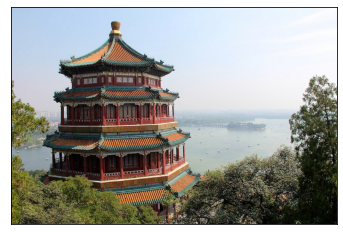

In [16]:
from sklearn.datasets import load_sample_image

image = load_sample_image('china.jpg')
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(image);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255:

In [17]:
image.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to $[$n_samples $\times$ n_features$]$, and rescale the colors so that they lie between 0 and 1:

In [18]:
data = image / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [19]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

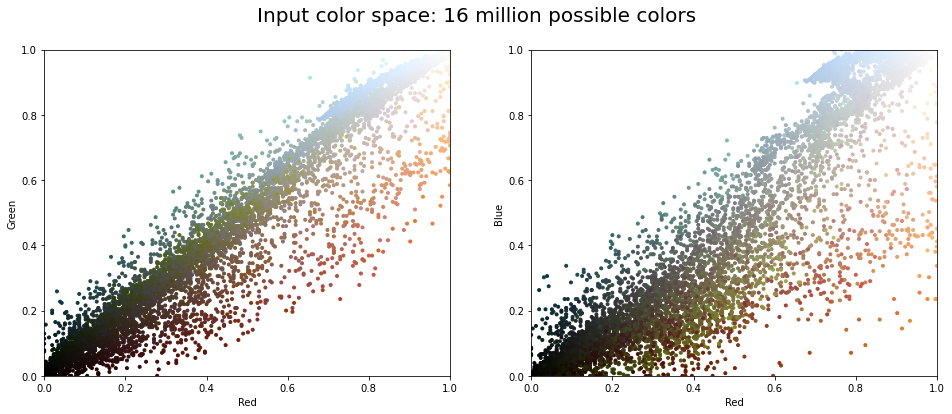

In [20]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using K-Means clustering across the pixel space.

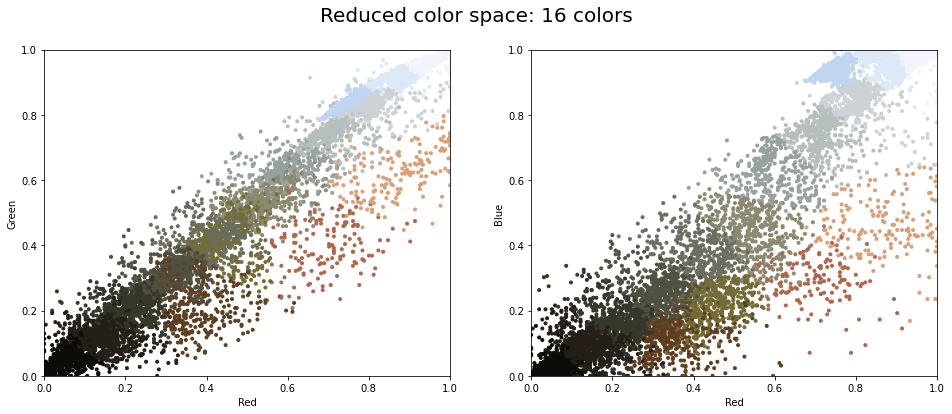

In [21]:
from sklearn.cluster import KMeans as KMeans_sklearn

kmeans = KMeans_sklearn(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

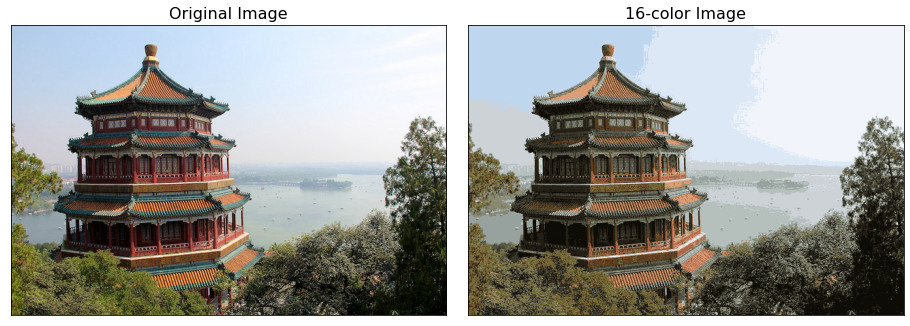

In [22]:
image_recolored = new_colors.reshape(image.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(image_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better ways to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.

# Cluster Validity Metrics

How would you evaluate clustering results? - **Cluster Validity Indices**
    
* Cluster validity indices are used for a number of different goals. For example, cluster validity metrics can be used to compare clustering results, try to determine the *correct* number of clusters, try to select the *correct* parameter settings, try to evaluate the approppriateness of the clustering result based on the data only (and not using another result or "ground truth" data).
    
In general, there are three types of **index criteria** to perform cluster validity:

1. **Internal criteria.** We evaluate the results of a clustering algorithm in terms of quantities that involve the vectors of the data set themselves. 
2. **External criteria.** We evaluate the results of a clustering algorithm based on a pre-specified structure, which is imposed on a data set and reflects our intuition about the clustering structure of the data set.
3. **Relative criteria.** We evaluate the results of a clustering structure by comparing it to other clustering schemes, resulting by the same algorithm but with different parameter values. In practice, relative criteria are a combination on internal and external criteria.

## Internal Criteria 

As the goal of clustering is to make objects within the same cluster similar and objects in different clusters distinct, internal cluster validity measures are defined by combining compactness and separability.

The optimal clustering scheme under the internal criteria index includes:

* Compactness (or intra-distance or within-cluster scatter): The members of each cluster should be as close to each other as possible. A common measure of compactness is the variance, which should be minimized.
* Separation (or inter-distance or between-cluster scatter): This indicates how distinct two clusters are. It computes the distance between two different clusters. There are three common approaches measuring the distance between two different clusters:
    * Single linkage: It measures the distance between the closest members of the clusters. 
    * Complete linkage: It measures the distance between the most distant members. 
    * Comparison of centroids: It measures the distance between the centers of the clusters. 

### Example: Silhouette Index

The Silhoute Index is an internal cluster validity index that is used to judge the quality of any clustering solution. 

Given a set of data points $X=\{x_1,\dots,x_N\}$ and a partition of $X$ (i.e. clustering result). Let's define the following:
* $a_i$ is the average distance of the point $x_i$ to all the other points of the cluster in which $x_i$ is assigned to
* $b_i$ is the average distance of the point $x_i$ to all the other points of in the other clusters. 

For every data point $x_i \in X$, the Silhouette Index is defined as:

$$s = \frac{1}{N} \sum_{i=1}^N \frac{b_i-a_i}{\max(a_i,b_i)}$$

* Silhouette index is the average silhouette of all data points and it reflects the compactness and separation of clusters.

* The value of silhouette index varies from -1 and 1 and higher indicates better clustering results.

There are many other internal cluster validity indices!

## External Criteria

External cluster validity indices are used to measure how well a clustering result matches a set of *give* labels. 
External cluster validity indices can be used to:
* compare the clustering results with the *ground truth* (true labels),
* compare clustering results between different clustering algorithms to measure how different they are and how stable a particular clustering is on a data set across parameter settings and/or algorithms.

### Example: Rand Index

The Rand Index is an external cluster validity index that is used to compare clustering results obtained from different parameter settings or algorithms. 

Given a set of data points $X$ and two partitions (i.e. clustering results) of $X$ to compare. One partition $C=\{C_1, \dots,C_k\}$, that partitions $X$ into $k$ clusters, and another partition $D=\{D_1,\dots,D_s\}$, that partitions $X$ into $s$ clusters. Let's define the following:

* $a$ is the number of pairs of elements in $X$ that are in the same subset in $C$ and in the same subset in $D$.
* $b$ is the number of pairs of elements in $X$ that are in different subset in $C$ and in different subset in $D$.
* $c$ is the number of pairs of elements in $X$ that are in the same subset in $C$ and in different subset in $D$.
* $d$ is the number of pairs of elements in $X$ that are in different subset in $C$ and in the same subset in $D$.

The Rand Index is defined as:

$$r = \frac{a+b}{a+b+c+d}$$

* Intuitively, $a+b$ can be considered as the number of *agreements* between $C$ and $D$, and $c+d$ as the number of *disagreements* between $C$ and $D$.

* The value of rand index varies from 0 and 1 and higher indicates higher consistency between partitions $C$ and $D$.

There are many other external cluster validity indices!